# <span style="color:blue">Stock prediction with Monte Carlo methods</span>
We demonstrate how to run Monte Carlo simulations with [lithops](https://github.com/lithops-cloud/lithops) over Cloud Functions. This notebook contains an example of stock prediction with Monte Carlo. The goal of this notebook is to demonstrate how Cloud Functions can benefit Monte Carlo simulations and not how stock prediction works. As stock prediction is very complicated and requires many prior knowledge and correct models, we did not innovate the Monte Carlo Method for handling the unpredictability of stock prices, nor do we provide any results for prediction based on long term data sources.

Requirements to run this notebook:

- IBM Cloud or a [Lithops-supported Cloud provider account](https://lithops-cloud.github.io/docs/source/compute_backends.html).
- You will need to have at least one existing object storage bucket.

## <span style="color:blue">Step 1  - Dependencies </span>

import and install dependencies

In [1]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import scipy.stats as scpy

#Install Lithops
try:
    import lithops
except:
    !pip install -r requirements.txt
    import lithops

# you can modify logging level if needed
#logging.basicConfig(level=logging.DEBUG)

## <span style="color:blue">Step 2 - Write Python code that implements Monte Carlo simulation </span>
Below is an example of Python code to demonstrate Monte Carlo model for stock prediction.

'StockData' is a  Python class that we use to represent a single stock. 
 You may configure the following parameters:

    MAP_INSTANCES - number of Cloud Function invocations. Default is 1000
    forecasts_per_map - number of forecasts to run in a single invocation. Default is 100
    day2predict - number of days to predict for each forecast. Default is 730 days

Our code contains two major Python methods:

    def process_forecasts(data=None) - a function to process number of forecasts and
      days as configured. (aka "map" in map-reduce paradigm)
    def combine_forecasts(results) - summarize results of all process_forecasts
      executions (aka "reduce" in map-reduce paradigm)
    
    

In [2]:
MAP_INSTANCES = 10

class StockData:
    forecasts_per_map = 100
    days2predict = 730

    def __init__(self, title, drift, std_dev, last_value):
        self.title = title
        self.last_value = last_value
        self.std_dev = std_dev
        self.drift = drift

    def single_forecast_generator(self):
        predicts_est = [self.last_value]
        for predict in range(1, self.days2predict + 1):
            rand = np.random.rand()
            pow_r = scpy.norm.ppf(rand)
            predicts_est.append(predicts_est[predict - 1] * np.exp(self.drift + (self.std_dev * pow_r)))
        return predicts_est

def process_forecasts(data=None):
    end = current_stock.days2predict
    mid = int(end / 2)
    hist_end = list()
    hist_mid = list()
    for i in range(StockData.forecasts_per_map):
        frc = current_stock.single_forecast_generator()
        hist_end.append(frc[end])
        hist_mid.append(frc[mid])
    return hist_mid, hist_end


def combine_forecasts(results):
    print(np.__version__)  # in order to import numpy
    hist_end = list()
    hist_mid = list()
    for single_map_result in results:
        hist_end.extend(single_map_result[1])
        hist_mid.extend(single_map_result[0])
    return (hist_mid, hist_end)


## <span style="color:blue">Step 3 - Configure access to your COS account and Cloud Functions</span>

Configure access details to your Cloud provider.  'storage_bucket'  should point to some pre-existing bucket. This bucket will be used by Lithops to store intermediate results. All results will be stored in the folder `lithops.jobs`. For additional configuration parameters see [configuration section](https://lithops-cloud.github.io/docs/source/configuration.html).

## <span style="color:blue">Step 4 - Input data on the past stock prices </span>
This step is mandatory to run our example. The raw stock daily data need to be prepared prior used by the code.
You can follow the next steps to create different input data. You may use any spreadsheet for this process or any other tool.

    * Fetch historical daily value of the stock from some reliable finance website
    * Calculate ln() function of two consecutive days ln (today price / yesterday price )
    * Calculate the variance 'var', the average 'u' and standard deviation of the previous results
    * Calculate the drift by equation drift = u - (var^2 / 2 )

In [3]:
total_forecasts = MAP_INSTANCES * StockData.forecasts_per_map

current_stock = StockData(title="Example 2014, 2015, 2016", drift=-0.00022513546014255100, std_dev=0.0121678341323272,
                               last_value=159.44)
print("Current Stock: " + current_stock.title)
print("Total Forecasts: " + str(total_forecasts))
print("Days to Predict: " + str(current_stock.days2predict))

Current Stock: Example 2014, 2015, 2016
Total Forecasts: 1000
Days to Predict: 730


## <span style="color:blue"> Step 5 - Execute simulation with Lithops over IBM Cloud Functions </span>

In [4]:
iterdata = [{"data": None}] * MAP_INSTANCES
start_time = time()
print ("Monte Carlo simulation for {} using {} forecasts spawing over {} Cloud Function invocations".format(current_stock.title, total_forecasts, MAP_INSTANCES))
# obtain lithops executor
fexec = lithops.FunctionExecutor()
# execute the code
fexec.map_reduce(process_forecasts, iterdata, combine_forecasts)
#get results
result = fexec.get_result()

elapsed = time()
print("\nCompleted in: " + str(elapsed - start_time) + " seconds")

2024-12-18 00:04:27,189 [INFO] config.py:139 -- Lithops v3.5.1 - Python3.10
2024-12-18 00:04:27,192 [INFO] localhost.py:39 -- Localhost storage client created
2024-12-18 00:04:27,193 [INFO] localhost.py:78 -- Localhost compute v2 client created
2024-12-18 00:04:27,216 [INFO] invokers.py:119 -- ExecutorID 77b0cb-0 | JobID M000 - Selected Runtime: python 
2024-12-18 00:04:27,219 [INFO] invokers.py:186 -- ExecutorID 77b0cb-0 | JobID M000 - Starting function invocation: process_forecasts() - Total: 10 activations
2024-12-18 00:04:27,249 [INFO] invokers.py:225 -- ExecutorID 77b0cb-0 | JobID M000 - View execution logs at /tmp/lithops-german/logs/77b0cb-0-M000.log
2024-12-18 00:04:27,250 [INFO] wait.py:105 -- ExecutorID 77b0cb-0 - Waiting for 20% of 10 function activations to complete


Monte Carlo simulation for Example 2014, 2015, 2016 using 1000 forecasts spawing over 10 Cloud Function invocations


    0%|          | 0/2  

2024-12-18 00:04:33,517 [INFO] invokers.py:119 -- ExecutorID 77b0cb-0 | JobID R000 - Selected Runtime: python 
2024-12-18 00:04:33,524 [INFO] invokers.py:186 -- ExecutorID 77b0cb-0 | JobID R000 - Starting function invocation: combine_forecasts() - Total: 1 activations
2024-12-18 00:04:33,525 [INFO] invokers.py:225 -- ExecutorID 77b0cb-0 | JobID R000 - View execution logs at /tmp/lithops-german/logs/77b0cb-0-R000.log
2024-12-18 00:04:33,526 [INFO] executors.py:494 -- ExecutorID 77b0cb-0 - Getting results from 1 function activations
2024-12-18 00:04:33,526 [INFO] wait.py:101 -- ExecutorID 77b0cb-0 - Waiting for 6 function activations to complete


    0%|          | 0/6  

2024-12-18 00:04:36,965 [INFO] executors.py:618 -- ExecutorID 77b0cb-0 - Cleaning temporary data



Completed in: 9.791324853897095 seconds


## <span style="color:blue">Step 6 - Print the graphs </span>

END Histogram for Example 2014, 2015, 2016 based on 1000 forecasts. Predicted price after 730 days


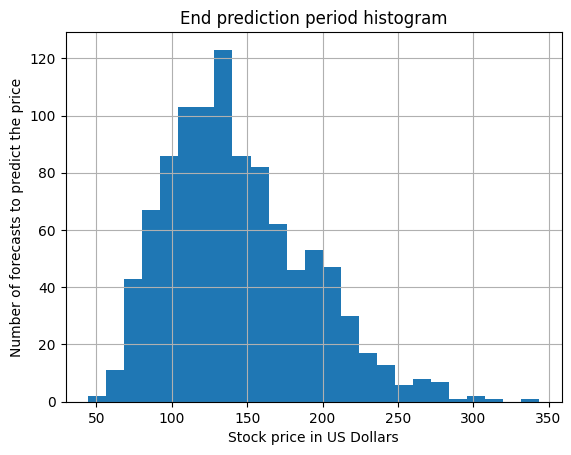

In [5]:
'''Histogram for end prediction forecast plot'''

end_data = result[1]
print("END Histogram for {} based on {} forecasts. Predicted price after {} days".format(current_stock.title,total_forecasts, current_stock.days2predict ))
plt.hist(end_data, bins='auto')
plt.grid(True)
plt.title("End prediction period histogram")
plt.ylabel("Number of forecasts to predict the price")
plt.xlabel("Stock price in US Dollars")
plt.show()